In [1]:
import os
import sys
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
sys.path.append('..')
from security_game.security_game import SecurityGame
from security_game.target import Target

In [2]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)
df

,animal_id,lat,long,timestamp
0,14118,2.476,15.769,2002-03-30 00:00:00.000
1,14118,2.502,15.740,2002-03-31 00:00:00.000
2,14118,2.506,15.744,2002-03-31 00:00:00.000
3,14118,2.507,15.747,2002-03-31 00:00:00.000
4,14118,2.479,15.771,2002-04-01 00:00:00.000
...,...,...,...,...
3178,46179,2.288,16.008,2004-08-11 01:37:19.000
3179,46179,2.286,16.007,2004-08-11 04:01:10.000
3180,46179,2.274,16.039,2004-08-11 06:55:32.000
3181,46179,2.297,16.012,2004-08-12 01:27:37.000


In [3]:
def get_density_scores(df, coordinate_rectangle, num_columns, num_rows):
    
    min_lat, max_lat, min_lon, max_lon = coordinate_rectangle
    cell_height = (max_lat - min_lat) / num_rows
    cell_width = (max_lon - min_lon) / num_columns

    # Filter points within the bounding box
    cell_df = df.copy(deep=True)[
        (df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
        (df['long'] >= min_lon) & (df['long'] <= max_lon)
    ]
    
    # Calculate grid cell indices for each point
    cell_df['row'] = np.floor((cell_df['lat'] - min_lat) / cell_height).astype(int)
    cell_df['col'] = np.floor((cell_df['long'] - min_lon) / cell_width).astype(int)

    # Count occurrences in each grid cell
    density_scores = (
        cell_df.groupby(['row', 'col'])
        .size()
        .to_dict()
    )

    return density_scores

def get_centroid_scores(df, coordinate_rectangle, num_columns, num_rows, num_clusters):
    """
    Assign scores to grid cells based on centroids from clustering animal data.
    
    df: DataFrame with columns ['animal_id', 'lat', 'long', 'timestamp'].
    coordinate_rectangle: Tuple (min_lat, max_lat, min_lon, max_lon).
    num_columns: Number of columns in the grid.
    num_rows: Number of rows in the grid.
    num_clusters: Number of clusters for k-means.
    returns: A dictionary mapping grid cell indices (row, col) to centroid scores.
    """
    min_lat, max_lat, min_lon, max_lon = coordinate_rectangle
    cell_height = (max_lat - min_lat) / num_rows
    cell_width = (max_lon - min_lon) / num_columns
    
    # Filter points within the bounding box
    cell_df = df.copy(deep=True)[
        (df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
        (df['long'] >= min_lon) & (df['long'] <= max_lon)
    ]
    
    # If no points remain after filtering, return empty results
    if cell_df.empty:
        return {}, (cell_width, cell_height)
    
    # Prepare data for clustering
    coordinates = cell_df[['lat', 'long']].to_numpy()
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    cell_df['cluster'] = kmeans.fit_predict(coordinates)
    
    # Get cluster centers and cluster sizes
    cluster_centers = kmeans.cluster_centers_
    cluster_sizes = cell_df.groupby('cluster').size().to_dict()
    
    # Map cluster centers to grid cells
    centroid_scores = {}
    for cluster_idx, (lat, lon) in enumerate(cluster_centers):
        
        # Determine grid cell
        row = int((lat - min_lat) / cell_height)
        col = int((lon - min_lon) / cell_width)
        
        # Add cluster size to the grid cell's score
        cell_key = (row, col)
        centroid_scores[cell_key] = centroid_scores.get(cell_key, 0) + cluster_sizes[cluster_idx]
    
    return centroid_scores

In [4]:
# Lobeke National Park Bounding Box
lat_min, lon_min = 2.05522, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

In [5]:
def plot_animal_locations(dataframe, coordinate_rectangle, title="Animal Locations"):
    """
    Plots animal location data spatially accurate within the input coordinate rectangle.

    :param dataframe: A pandas DataFrame with columns ['animal_id', 'lat', 'long', 'timestamp'].
    :param coordinate_rectangle: A tuple of (min_lat, max_lat, min_long, max_long).
    :param title: Title for the plot (default "Animal Locations").
    """
    # Extract coordinate bounds
    min_lat, max_lat, min_long, max_long = coordinate_rectangle

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot of animal locations
    scatter = ax.scatter(
        dataframe['long'], dataframe['lat'], 
        c='blue', alpha=0.6, edgecolors='k', label="Animal Location"
    )

    # Set axis limits based on coordinate rectangle
    ax.set_xlim(min_long, max_long)
    ax.set_ylim(min_lat, max_lat)

    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(title)

    # Add legend
    ax.legend(loc="upper right")

    # Display the plot
    plt.show()

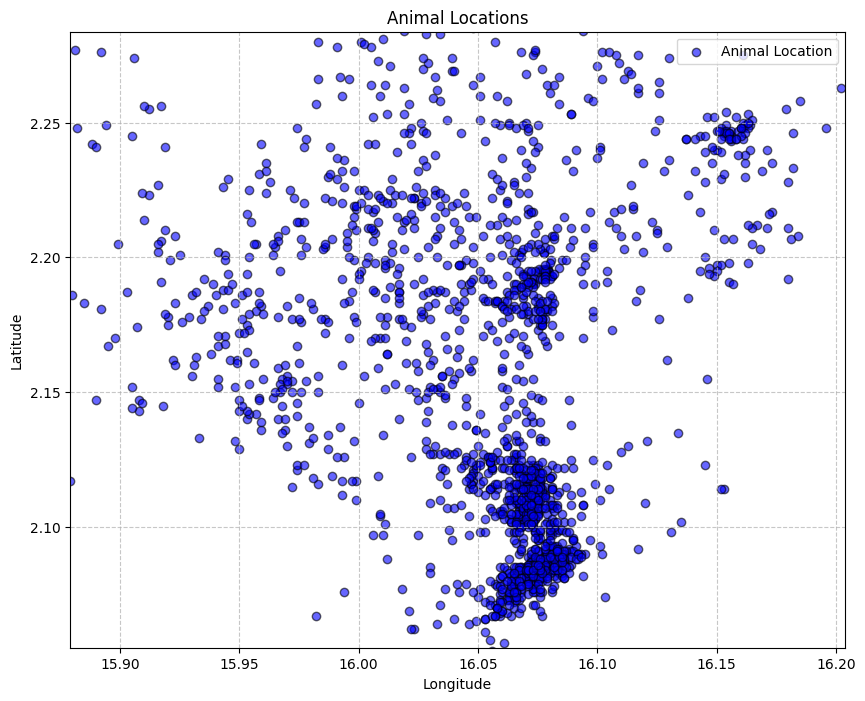

In [6]:
plot_animal_locations(df, (lat_min, lat_max, lon_min, lon_max))

In [36]:
class GreenSecurityGame:
    def __init__(self, data, coordinate_rectangle, scoring_method, num_clusters=None, num_rows=5, num_columns=5):
        self.data = data
        self.coordinate_rectangle = coordinate_rectangle
        self.scoring_method = scoring_method
        self.num_clusters = num_clusters
        self.num_rows = num_rows
        self.num_columns = num_columns
        self.graph = None
        self.defender_strategies = None
        self.attacker_strategies = None
        self.utility_matrix = None

    def create_grid(self):
        min_lat, max_lat, min_long, max_long = self.coordinate_rectangle
        lats = np.linspace(min_lat, max_lat, self.num_rows + 1)
        longs = np.linspace(min_long, max_long, self.num_columns + 1)

        cell_side_length_km = (
            geodesic((min_lat, min_long), (max_lat, min_long)).km / self.num_rows,
            geodesic((min_lat, min_long), (min_lat, max_long)).km / self.num_columns,
        )

        grid = [
            (lats[i], lats[i + 1], longs[j], longs[j + 1])
            for i in range(self.num_rows)
            for j in range(self.num_columns)
        ]

        return grid, cell_side_length_km

    def get_scores(self):
        if self.scoring_method == "density":
            return get_density_scores(self.data, self.coordinate_rectangle, self.num_columns, self.num_rows)
        elif self.scoring_method == "centroid":
            if not self.num_clusters:
                raise ValueError("num_clusters must be specified for centroid scoring method.")
            return get_centroid_scores(self.data, self.coordinate_rectangle, self.num_columns, self.num_rows, self.num_clusters)
        else:
            raise ValueError("Invalid scoring method. Choose 'density' or 'centroid'.")

    def fill_missing_cells(self, grid_dict):
        for row in range(self.num_rows):
            for col in range(self.num_columns):
                if (row, col) not in grid_dict:
                    grid_dict[(row, col)] = 0
        return grid_dict

    def convert_to_graph(self, grid_dict):
        G = nx.Graph()

        max_value = max(grid_dict.values())
        min_value = min(grid_dict.values())
        range_value = max_value - min_value

        normalized_values = {
            key: (value - min_value) / range_value if range_value > 0 else 1.0
            for key, value in grid_dict.items()
        }

        for (row, col), norm_value in normalized_values.items():
            inverted_row = self.num_rows - 1 - row
            G.add_node((inverted_row, col), score=norm_value, position=(row, col))

        for inverted_row in range(self.num_rows):
            for col in range(self.num_columns):
                neighbors = [(inverted_row, col + 1), (inverted_row + 1, col)]
                for neighbor in neighbors:
                    if neighbor in G.nodes:
                        G.add_edge((inverted_row, col), neighbor)

        return nx.convert_node_labels_to_integers(G, label_attribute="position")

    def get_home_base_label(self, home_base):
        """
        Get the integer label of the home base node in the graph.
    
        returns: Integer label of the home base node.
        raises: ValueError: If the home base node is not found in the graph.
        """
        if not hasattr(self, 'graph') or self.graph is None:
            raise ValueError("Graph has not been created. Run generate() first.")
    
        for node, attributes in self.graph.nodes(data=True):
            if attributes.get("position") == home_base:
                return node
    
        raise ValueError(f"Home base node with position {self.home_base} not found in the graph.")

    def draw_graph(self, figsize=(12, 10), base_node_size=300, font_size=10, cmap='Blues'):
        """
        Draws the graph using the positions stored in the node "position" attribute.
        Node sizes and colors are scaled with the node "score" attribute.
    
        graph: The NetworkX graph to draw.
        figsize: Tuple specifying the figure size.
        base_node_size: Base size for the nodes; scaling is applied relative to this.
        font_size: Font size for node labels.
        cmap: Colormap for scaling node colors.
        """

        if not hasattr(self, 'graph') or self.graph is None:
            raise ValueError("Graph has not been created. Run generate() first.")
    
        # Determine grid dimensions for y-axis inversion
        max_row = max(node[1]["position"][0] for node in self.graph.nodes(data=True))
    
        # Corrected node positions to invert rows
        positions = {node[0]: (node[1]["position"][1], max_row - node[1]["position"][0]) for node in self.graph.nodes(data=True)}  # (col, inverted row)
    
        # Extract node scores for scaling
        scores = nx.get_node_attributes(self.graph, "score")
        if not scores:
            raise ValueError("The graph does not have 'score' attributes for its nodes.")
    
        # Normalize scores for node size and color scaling
        score_values = np.array(list(scores.values()))
        min_score, max_score = score_values.min(), score_values.max()
        normalized_scores = (score_values - min_score) / (max_score - min_score + 1e-6)
    
        # Scale node sizes and colors
        node_sizes = base_node_size * (1 + normalized_scores)  # Scale size with scores
        node_colors = normalized_scores  # Use normalized scores for colors
    
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)
    
        # Draw the graph
        nodes = nx.draw_networkx_nodes(
            self.graph,
            pos=positions,
            node_color=node_colors,
            node_size=node_sizes,
            edgecolors="black",
            cmap=cmap,
            ax=ax
        )
        edges = nx.draw_networkx_edges(self.graph, pos=positions, ax=ax)
        labels = nx.draw_networkx_labels(self.graph, pos=positions, font_size=font_size, ax=ax)
    
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_score, vmax=max_score))
        sm.set_array([])  # Dummy array for the colorbar
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Node Score')
    
        # Show plot
        plt.title("Graph Visualization with Node Scores")
        plt.axis("off")
        plt.show()

    def generate(self, num_attackers, num_defenders, home_base, num_timesteps, interdiction_protocol=None, defense_time_threshold=2):
        grid, _ = self.create_grid()
        scores = self.get_scores()
        scores = self.fill_missing_cells(scores)
        self.graph = self.convert_to_graph(scores)

        targets = [
            Target(node=i, value=data["score"])
            for i, data in self.graph.nodes(data=True)
            if data["score"] > 0
        ]

        home_base_label = self.get_home_base_label(home_base)

        game = SecurityGame(
            num_attackers=num_attackers,
            num_defenders=num_defenders,
            graph=self.graph,
            targets=targets,
            num_timesteps=num_timesteps,
            defender_start_nodes=[home_base_label],
            defender_end_nodes=[home_base_label],
            interdiction_protocol=interdiction_protocol,
            defense_time_threshold=defense_time_threshold,
        )

        self.defender_strategies = game.generate_strategy_matrix("defender")
        self.attacker_strategies = game.generate_strategy_matrix("attacker")

        self.utility_matrix = game.generate_utility_matrix()


In [37]:
gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=5, num_rows=5, num_columns=5)

In [38]:
gsg.generate(num_attackers=2, num_defenders=1, home_base=(3,3), num_timesteps=8)

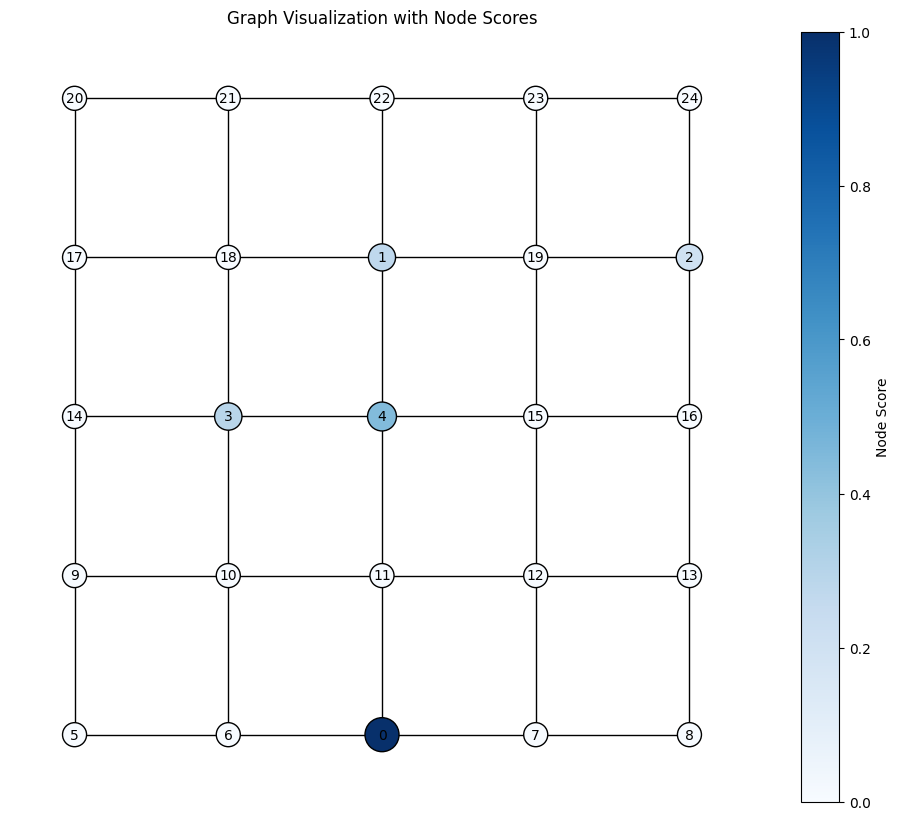

In [40]:
gsg.draw_graph()

In [33]:
len(gsg.defender_strategies)

3571

In [34]:
len(gsg.attacker_strategies)

36

In [45]:
gsg.utility_matrix

array([[-1.        , -1.27158774, -1.20612813, ..., -0.29387187,
        -0.44428969,  0.        ],
       [-1.        , -1.27158774, -1.20612813, ..., -0.29387187,
        -0.44428969,  0.        ],
       [-1.        , -1.27158774, -1.20612813, ..., -0.29387187,
        -0.44428969,  0.        ],
       ...,
       [-1.        , -1.27158774, -1.20612813, ..., -0.29387187,
        -0.44428969,  0.        ],
       [-1.        , -1.27158774, -1.20612813, ..., -0.29387187,
        -0.44428969,  0.        ],
       [-1.        , -1.27158774, -1.20612813, ..., -0.29387187,
        -0.44428969,  0.        ]])